# Resimulation analysis

In [1]:
# Importing external packages

import os
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
from collections import defaultdict
from tqdm import tqdm
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import dimensional_stacking
import importlib
import warnings
warnings.filterwarnings(action='once')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


In [2]:
# Importing model scripts, by first adding the main folder path

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.model_nile import ModelNile
from experimentation.data_generation import generate_input_data
import plotter

import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 16

Read the results of the open exploration:

In [3]:
experiments = pd.read_csv("../outputs/experiments_resimulation.csv").drop(
    columns="Unnamed: 0"
)
outcomes = pd.read_csv("../outputs/outcomes_resimulation.csv").drop(
    columns="Unnamed: 0"
)

In [4]:
experiments.head(15)

,yearly_demand_growth_rate,blue_nile_mean_coef,white_nile_mean_coef,atbara_mean_coef,blue_nile_dev_coef,white_nile_dev_coef,atbara_dev_coef,v0,v1,v2,...,v157,v158,v159,v160,v161,v162,v163,scenario,policy,model
0,0.0212,1.00,1.00,1.00,1.0,1.0,1.0,0.005230,0.087435,0.580001,...,0.534270,-0.553612,0.148301,0.390411,0.315424,0.513462,0.395253,Baseline,Policy0,NileProblem
1,0.0300,0.75,0.75,0.75,1.0,1.0,1.0,0.005230,0.087435,0.580001,...,0.534270,-0.553612,0.148301,0.390411,0.315424,0.513462,0.395253,ExtremeStress,Policy0,NileProblem
2,0.0300,0.75,1.25,1.25,1.0,1.0,1.0,0.005230,0.087435,0.580001,...,0.534270,-0.553612,0.148301,0.390411,0.315424,0.513462,0.395253,CompensatedStress,Policy0,NileProblem
3,0.0100,1.00,1.00,1.00,1.0,1.0,1.0,0.005230,0.087435,0.580001,...,0.534270,-0.553612,0.148301,0.390411,0.315424,0.513462,0.395253,LowDemand,Policy0,NileProblem
4,0.0212,1.25,1.00,1.00,1.0,1.0,1.0,0.005230,0.087435,0.580001,...,0.534270,-0.553612,0.148301,0.390411,0.315424,0.513462,0.395253,HighBlueNile,Policy0,NileProblem
5,0.0212,1.00,1.00,1.00,1.0,1.0,1.0,0.005551,0.114852,0.416813,...,0.538180,0.926470,0.776713,0.359905,0.096117,0.706763,0.365144,Baseline,Policy1,NileProblem
6,0.0300,0.75,0.75,0.75,1.0,1.0,1.0,0.005551,0.114852,0.416813,...,0.538180,0.926470,0.776713,0.359905,0.096117,0.706763,0.365144,ExtremeStress,Policy1,NileProblem
7,0.0300,0.75,1.25,1.25,1.0,1.0,1.0,0.005551,0.114852,0.416813,...,0.538180,0.926470,0.776713,0.359905,0.096117,0.706763,0.365144,CompensatedStress,Policy1,NileProblem
8,0.0100,1.00,1.00,1.00,1.0,1.0,1.0,0.005551,0.114852,0.416813,...,0.538180,0.926470,0.776713,0.359905,0.096117,0.706763,0.365144,LowDemand,Policy1,NileProblem
9,0.0212,1.25,1.00,1.00,1.0,1.0,1.0,0.005551,0.114852,0.416813,...,0.538180,0.926470,0.776713,0.359905,0.096117,0.706763,0.365144,HighBlueNile,Policy1,NileProblem


In [5]:
# merged_df = pd.merge(experiments,outcomes, left_index=True, right_index=True)
# levers = [f"v{i}" for i in range(164)]
# objs = list(outcomes.columns)
# merged_df.loc[merged_df["scenario"] == "OptimScen", levers + objs].reset_index().drop(columns = "index").to_csv("../outputs/baseline_results1.csv",index=True)

In [6]:
def normalize_objs(df, directions):
    desirability_couples = list()
    working_df = df.copy()
    for i, col in enumerate(df.columns):
        if directions[i] == "min":
            best, worst = df[col].min(), df[col].max()
        elif directions[i] == "max":
            best, worst = df[col].max(), df[col].min()
        desirability_couples.append((worst, best))
        working_df[col] = (df[col] - worst) / (best - worst)

    return working_df, desirability_couples

In [7]:
from scipy.stats import linregress

In [8]:
scenario_indexes = {
    scen: list(experiments.loc[experiments["scenario"] == scen].index)
    for scen in experiments["scenario"].unique()
}
slope_dfs = {}
corr_dfs = {}


for scen, indexes in scenario_indexes.items():
    print("---------------------------------")
    print(scen)
    print("---------------------------------")
    norm_df, desire_couples = normalize_objs(
        outcomes.loc[indexes],
        ["min", "min", "min", "min", "min", "max"]
    )

    cor_template = norm_df.corr()
    reg_template = cor_template.copy()
    
    for name1 in cor_template.columns:
        for name2 in cor_template.columns:
            if name1 == name2:
                cor_template.at[name1, name2] = None
#             if name1 == "sudan_90" or name2 == "sudan_90":
#                 cor_template.at[name1, name2] = None
#                 reg_template.at[name1, name2] = None
            if cor_template.loc[name1, name2] is None:
                continue

            slope, intercept, r_value, p_value, std_err = linregress(
                x=norm_df[name1], y=norm_df[name2]
            )
            if reg_template.at[name1, name2] == cor_template.at[name1, name2]:
                if abs(slope) > 1:
                    slope = 1/slope
                
                reg_template.at[name1, name2] = slope
                reg_template.at[name2, name1] = slope

            # dif_series = abs(norm_df[name1] - norm_df[name2])
            # cor_template.at[name1,name2] = dif_series.mean()

    slope_dfs[scen] = reg_template
    corr_dfs[scen] = cor_template
    print(outcomes.loc[indexes].describe())
    outcomes.loc[indexes].describe().to_excel(f"../plots/tables/{scen}_statistics.xlsx")

---------------------------------
Baseline
---------------------------------
        egypt_irr    egypt_90  egypt_low_had   sudan_irr    sudan_90  \
count  340.000000  340.000000     340.000000  340.000000  340.000000   
mean     5.799038    1.425814       0.277279    0.137928    0.012462   
std      2.807234    0.757129       0.236762    0.196730    0.034875   
min      3.499272    0.508538       0.000000    0.000000    0.000000   
25%      4.502679    1.051275       0.087500    0.001429    0.000000   
50%      5.002051    1.285461       0.216667    0.048857    0.000000   
75%      5.941854    1.527429       0.391667    0.160708    0.000000   
max     18.462717    5.171043       0.883333    0.724290    0.172364   

       ethiopia_hydro  
count      340.000000  
mean        13.941639  
std          1.303515  
min          9.424000  
25%         13.235413  
50%         14.330341  
75%         15.012950  
max         15.125298  
---------------------------------
ExtremeStress
----------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` a


---------------------------------
HighBlueNile
---------------------------------
        egypt_irr    egypt_90  egypt_low_had   sudan_irr  sudan_90  \
count  340.000000  340.000000     340.000000  340.000000     340.0   
mean     8.035590    2.435154       0.003051    0.088230       0.0   
std      2.294509    0.612739       0.039728    0.116758       0.0   
min      3.080488    1.012121       0.000000    0.000000       0.0   
25%      5.989659    1.974308       0.000000    0.000000       0.0   
50%      8.991610    2.671510       0.000000    0.024364       0.0   
75%      9.854999    2.835433       0.000000    0.177164       0.0   
max     13.433690    3.969714       0.520833    0.418231       0.0   

       ethiopia_hydro  
count      340.000000  
mean        18.625667  
std          1.566079  
min         10.808959  
25%         18.901276  
50%         19.101250  
75%         19.238724  
max         19.261798  


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


In [9]:
slope, intercept, r_value, p_value, std_err = linregress(
    x=outcomes["egypt_90"], y=outcomes["egypt_irr"]
)
1 / slope

0.24644479389865073

In [10]:
pd.set_option("precision", 2)
from  matplotlib.colors import LinearSegmentedColormap
my_cmap=LinearSegmentedColormap.from_list('rg',["salmon", "w", "cornflowerblue"], N=256) 

In [11]:
obj_names = {
    "egypt_irr": "Egypt Irr. Deficit",
    "egypt_90": "Egypt 90th Irr. Deficit",
    "egypt_low_had": "Egypt Low HAD",
    "sudan_irr": "Sudan Irr. Deficit",
    "sudan_90": "Sudan 90th Irr. Deficit",
    "ethiopia_hydro": "Ethiopia Hydropower",
}

In [12]:
for scen in experiments["scenario"].unique():
    print("---------")
    print(scen)
    print("---------\n")
    slope_df = slope_dfs[scen].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
        ).rename(columns=obj_names,index=obj_names
        ).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)
    slope_df
    slope_df.to_excel(f"../plots/tables/{scen}_scenario_regression_slopes.xlsx")
    
    corr_df = corr_dfs[scen].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
        ).rename(columns=obj_names,index=obj_names
        ).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)
    corr_df
    corr_df.to_excel(f"../plots/tables/{scen}_scenario_correlations.xlsx")
    

---------
Baseline
---------

---------
ExtremeStress
---------

---------
CompensatedStress
---------

---------
LowDemand
---------

---------
HighBlueNile
---------



In [13]:
slope_dfs["Baseline"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.81,-0.43,0.95,0.62,-0.43
Egypt 90th Irr. Deficit,0.81,1.00,-0.69,0.89,0.75,-0.56
Egypt Low HAD,-0.43,-0.69,1.00,-0.19,-0.15,-0.08
Sudan Irr. Deficit,0.95,0.89,-0.19,1.00,0.60,-0.40
Sudan 90th Irr. Deficit,0.62,0.75,-0.15,0.60,1.00,-0.35
Ethiopia Hydropower,-0.43,-0.56,-0.08,-0.40,-0.35,1.00


In [14]:
corr_dfs["Baseline"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.93,-0.30,0.65,0.58,-0.36
Egypt 90th Irr. Deficit,0.93,1.00,-0.42,0.68,0.60,-0.39
Egypt Low HAD,-0.30,-0.42,1.00,-0.19,-0.20,-0.09
Sudan Irr. Deficit,0.65,0.68,-0.19,1.00,0.80,-0.47
Sudan 90th Irr. Deficit,0.58,0.60,-0.20,0.80,1.00,-0.31
Ethiopia Hydropower,-0.36,-0.39,-0.09,-0.47,-0.31,1.00


In [15]:
slope_dfs["ExtremeStress"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,-0.09,-0.19,-0.01,0.08,-0.71
Egypt 90th Irr. Deficit,-0.09,1.00,0.36,-0.10,-0.08,0.36
Egypt Low HAD,-0.19,0.36,1.00,-0.68,-0.82,-0.07
Sudan Irr. Deficit,-0.01,-0.10,-0.68,1.00,0.89,-0.05
Sudan 90th Irr. Deficit,0.08,-0.08,-0.82,0.89,1.00,0.01
Ethiopia Hydropower,-0.71,0.36,-0.07,-0.05,0.01,1.00


In [16]:
corr_dfs["ExtremeStress"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,-0.09,-0.24,-0.01,0.05,-0.60
Egypt 90th Irr. Deficit,-0.09,1.00,0.48,-0.08,-0.06,0.16
Egypt Low HAD,-0.24,0.48,1.00,-0.43,-0.42,-0.02
Sudan Irr. Deficit,-0.01,-0.08,-0.43,1.00,0.93,-0.02
Sudan 90th Irr. Deficit,0.05,-0.06,-0.42,0.93,1.00,0.00
Ethiopia Hydropower,-0.60,0.16,-0.02,-0.02,0.00,1.00


In [17]:
slope_dfs["CompensatedStress"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.59,-0.79,0.53,0.71,-0.86
Egypt 90th Irr. Deficit,0.59,1.00,0.05,0.12,0.14,0.22
Egypt Low HAD,-0.79,0.05,1.00,-0.24,-0.29,-0.31
Sudan Irr. Deficit,0.53,0.12,-0.24,1.00,0.85,-0.41
Sudan 90th Irr. Deficit,0.71,0.14,-0.29,0.85,1.00,-0.38
Ethiopia Hydropower,-0.86,0.22,-0.31,-0.41,-0.38,1.00


In [18]:
corr_dfs["CompensatedStress"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.43,-0.52,0.44,0.48,-0.42
Egypt 90th Irr. Deficit,0.43,1.00,0.04,0.14,0.13,0.15
Egypt Low HAD,-0.52,0.04,1.00,-0.30,-0.29,-0.23
Sudan Irr. Deficit,0.44,0.14,-0.30,1.00,0.95,-0.24
Sudan 90th Irr. Deficit,0.48,0.13,-0.29,0.95,1.00,-0.28
Ethiopia Hydropower,-0.42,0.15,-0.23,-0.24,-0.28,1.00


In [19]:
slope_dfs["LowDemand"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.93,-0.08,0.42,0.17,-0.26
Egypt 90th Irr. Deficit,0.93,1.00,-0.06,0.33,0.16,-0.22
Egypt Low HAD,-0.08,-0.06,1.00,0.42,0.23,-0.29
Sudan Irr. Deficit,0.42,0.33,0.42,1.00,0.21,-0.32
Sudan 90th Irr. Deficit,0.17,0.16,0.23,0.21,1.00,-0.24
Ethiopia Hydropower,-0.26,-0.22,-0.29,-0.32,-0.24,1.00


In [20]:
corr_dfs["LowDemand"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Sudan 90th Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.99,-0.12,0.28,0.27,-0.24
Egypt 90th Irr. Deficit,0.99,1.00,-0.09,0.25,0.29,-0.21
Egypt Low HAD,-0.12,-0.09,1.00,0.20,0.26,-0.18
Sudan Irr. Deficit,0.28,0.25,0.20,1.00,0.50,-0.42
Sudan 90th Irr. Deficit,0.27,0.29,0.26,0.50,1.00,-0.14
Ethiopia Hydropower,-0.24,-0.21,-0.18,-0.42,-0.14,1.00


In [21]:
slope_dfs["HighBlueNile"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.92,-0.02,-0.22,-0.31
Egypt 90th Irr. Deficit,0.92,1.00,-0.01,-0.09,-0.39
Egypt Low HAD,-0.02,-0.01,1.00,0.76,-0.07
Sudan Irr. Deficit,-0.22,-0.09,0.76,1.00,-0.17
Ethiopia Hydropower,-0.31,-0.39,-0.07,-0.17,1.00


In [22]:
corr_dfs["HighBlueNile"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(1
).rename(columns=obj_names,index=obj_names
).style.background_gradient(axis=None,cmap = my_cmap, vmin=-1, vmax=1)

,Egypt Irr. Deficit,Egypt 90th Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Ethiopia Hydropower
Egypt Irr. Deficit,1.00,0.98,-0.05,-0.18,-0.37
Egypt 90th Irr. Deficit,0.98,1.00,-0.01,-0.07,-0.43
Egypt Low HAD,-0.05,-0.01,1.00,0.21,-0.03
Sudan Irr. Deficit,-0.18,-0.07,0.21,1.00,-0.26
Ethiopia Hydropower,-0.37,-0.43,-0.03,-0.26,1.00


---------
Baseline
---------



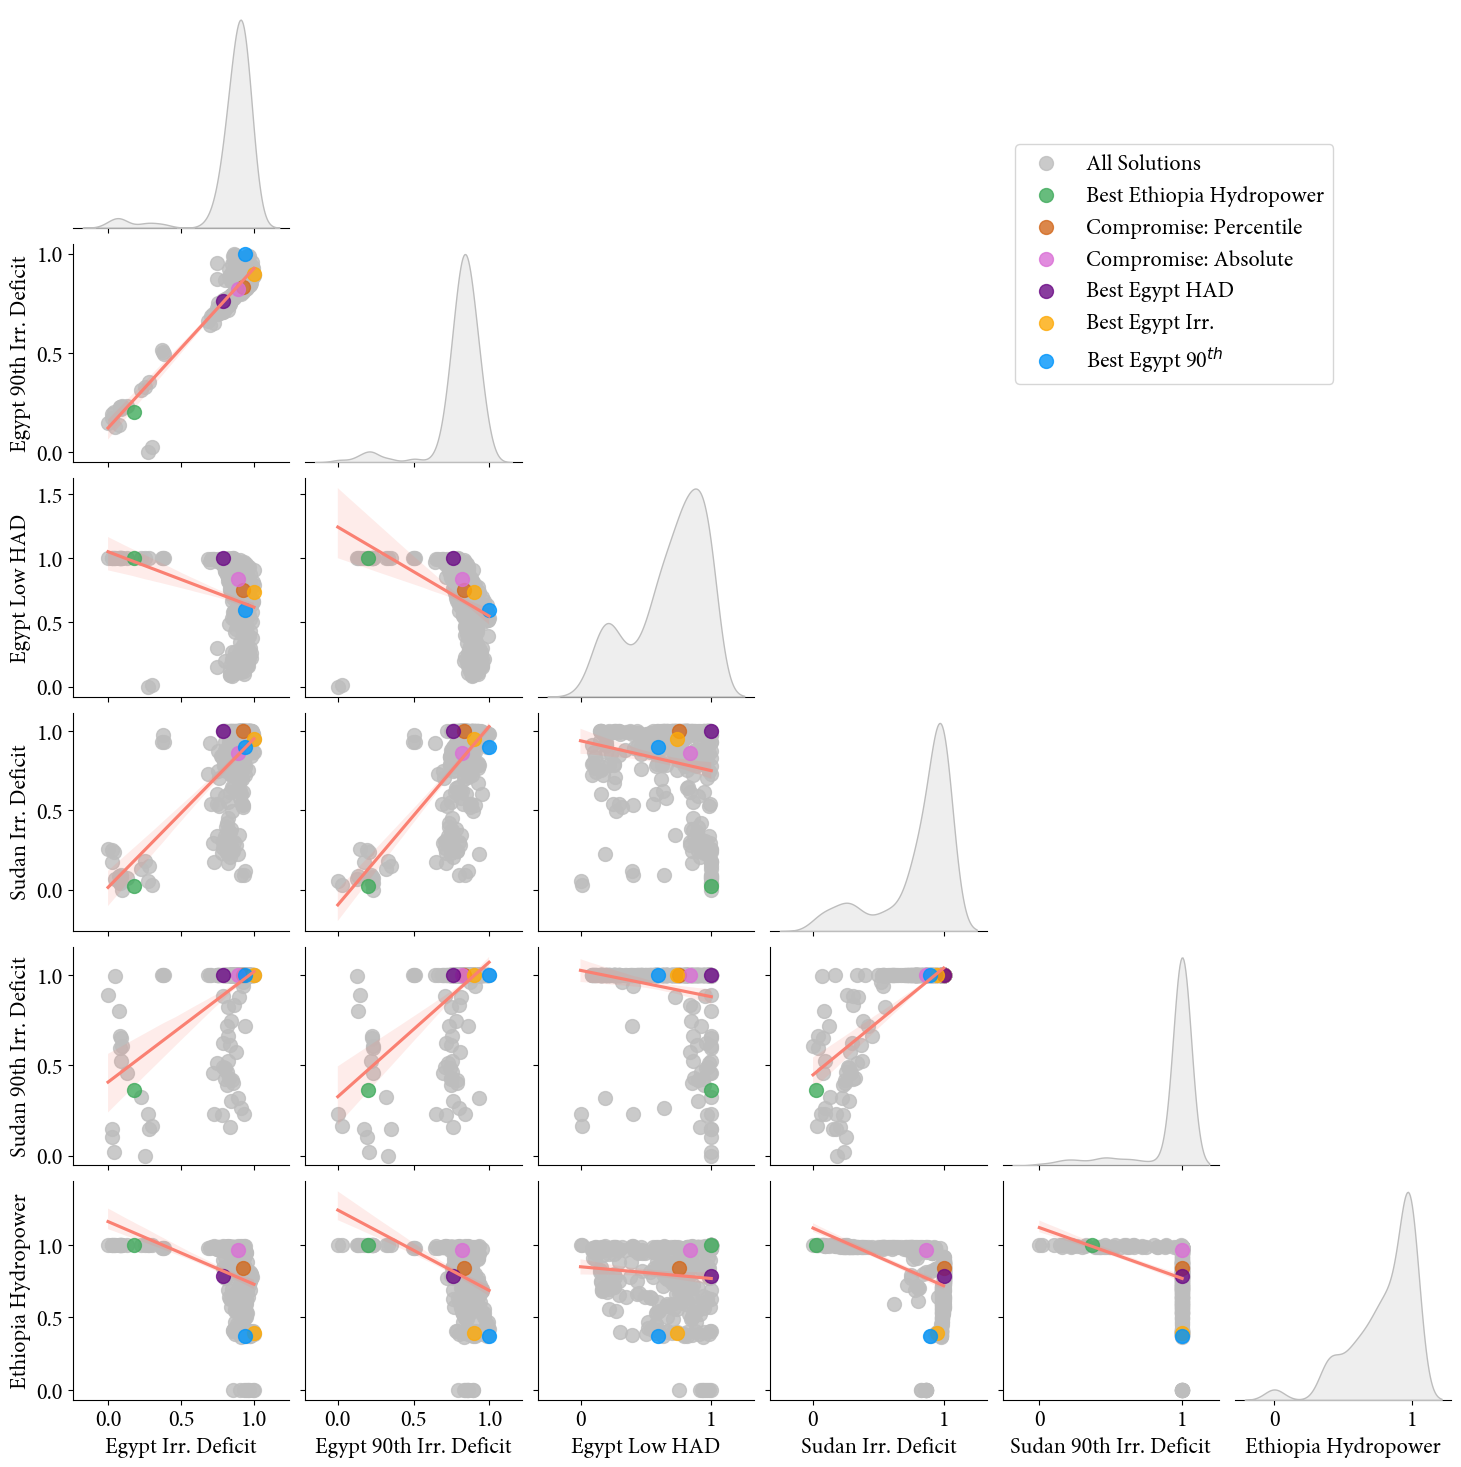

---------
ExtremeStress
---------



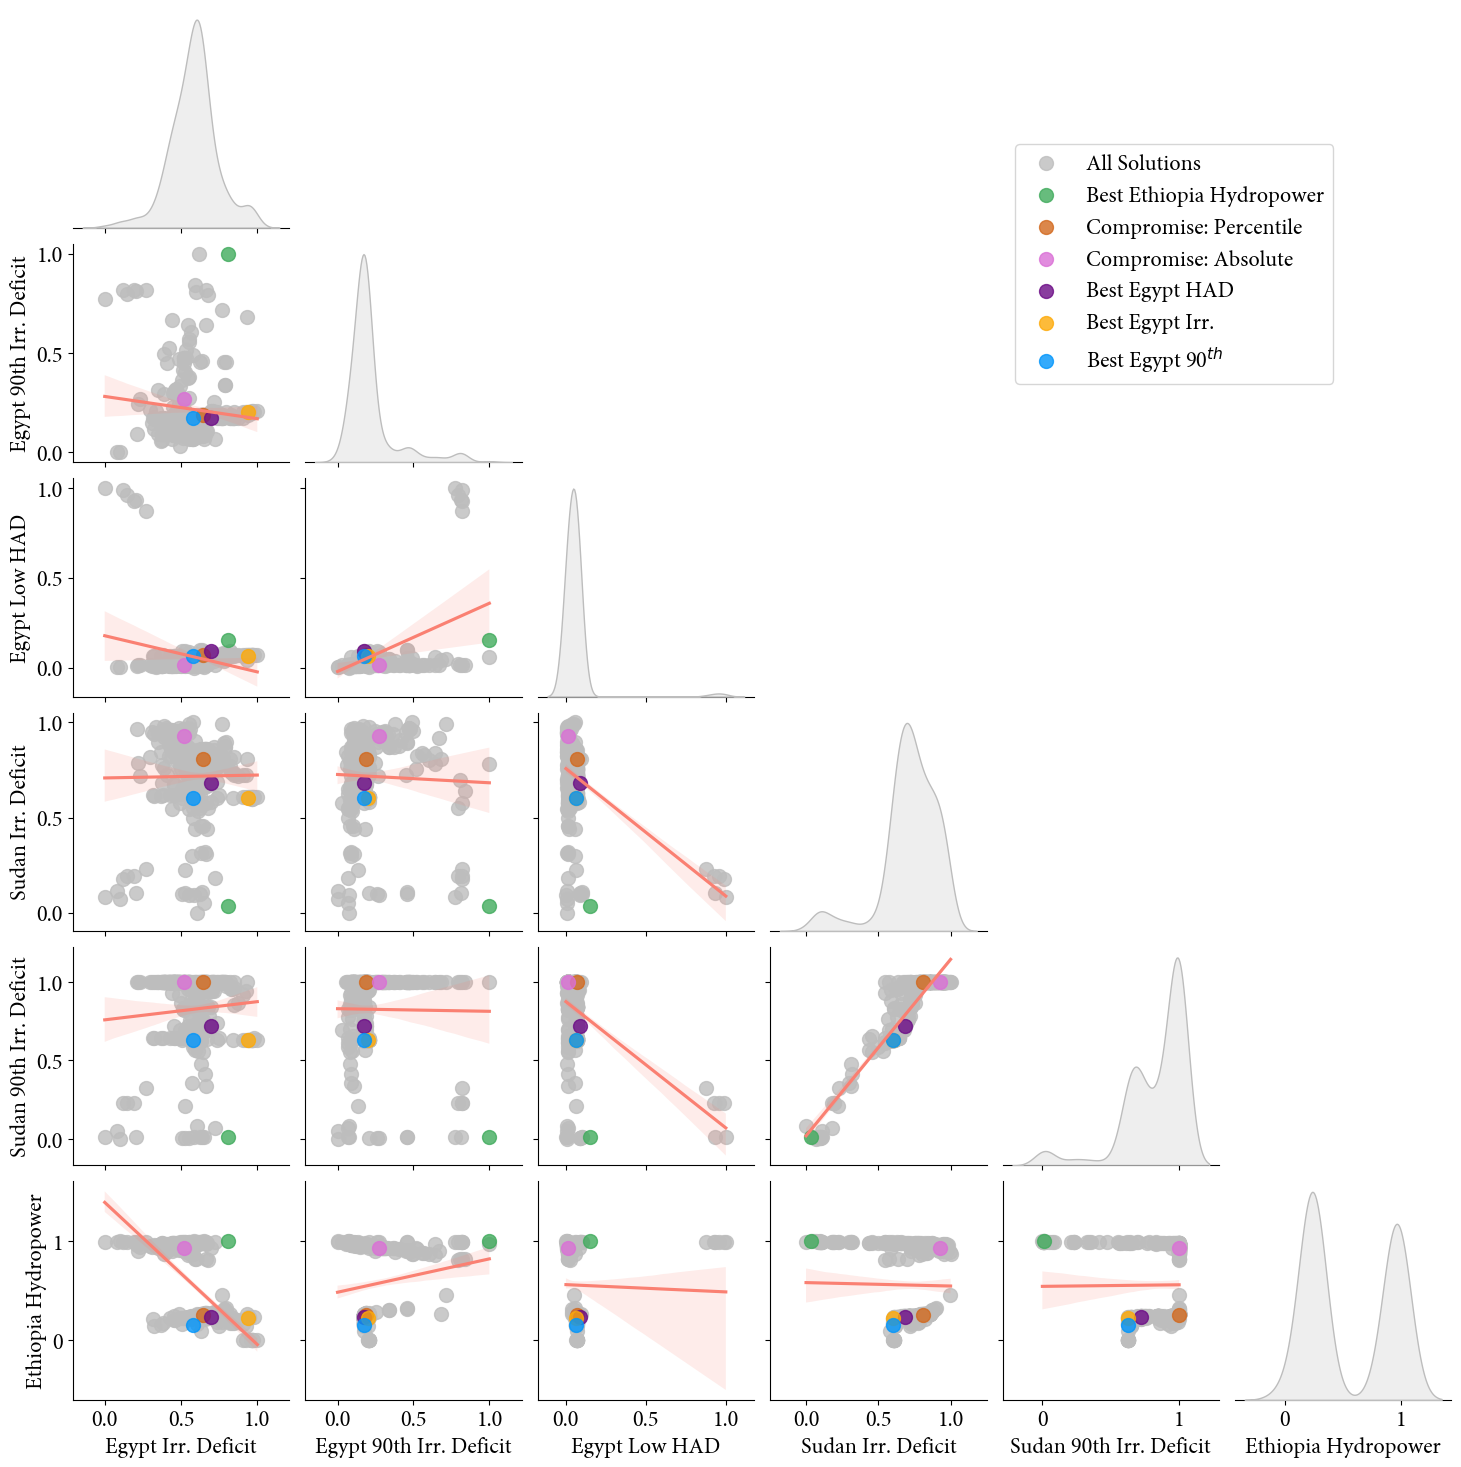

---------
CompensatedStress
---------



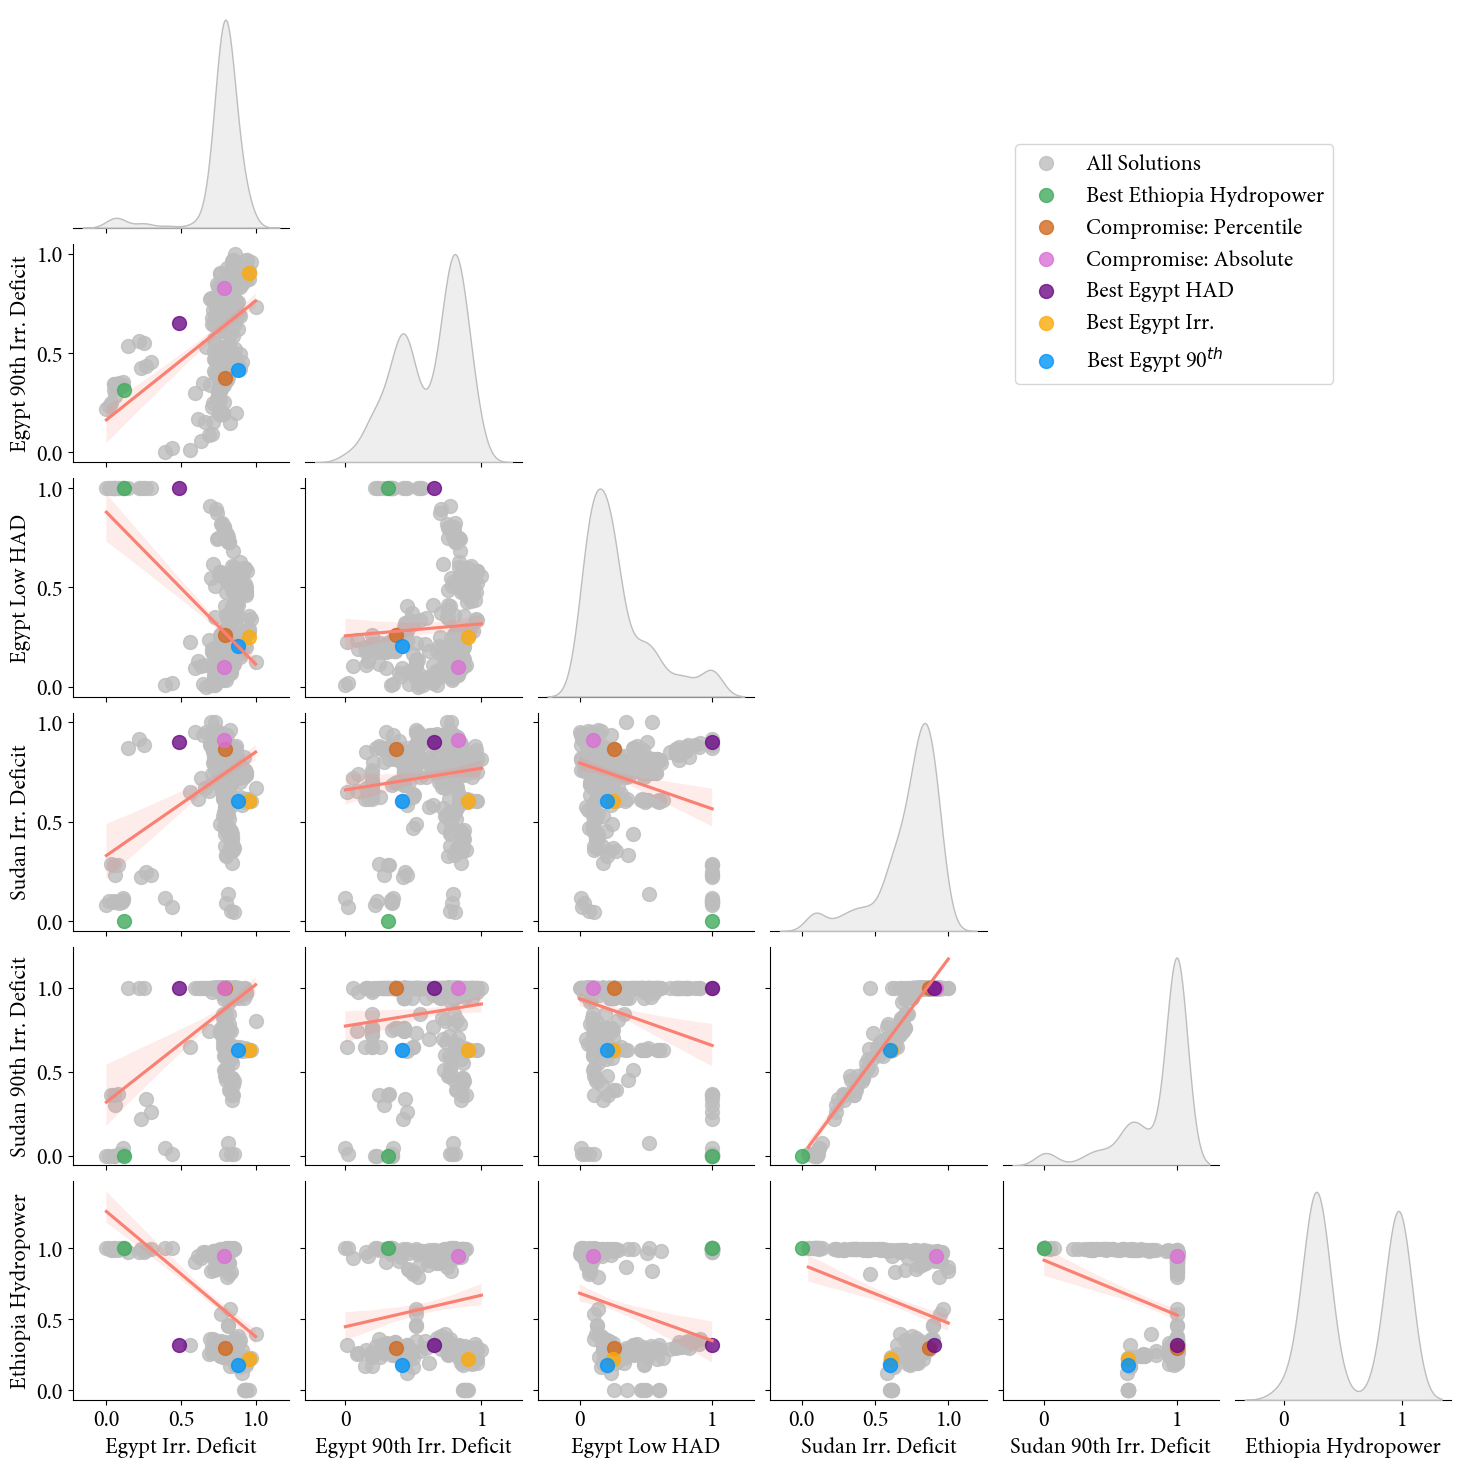

---------
LowDemand
---------



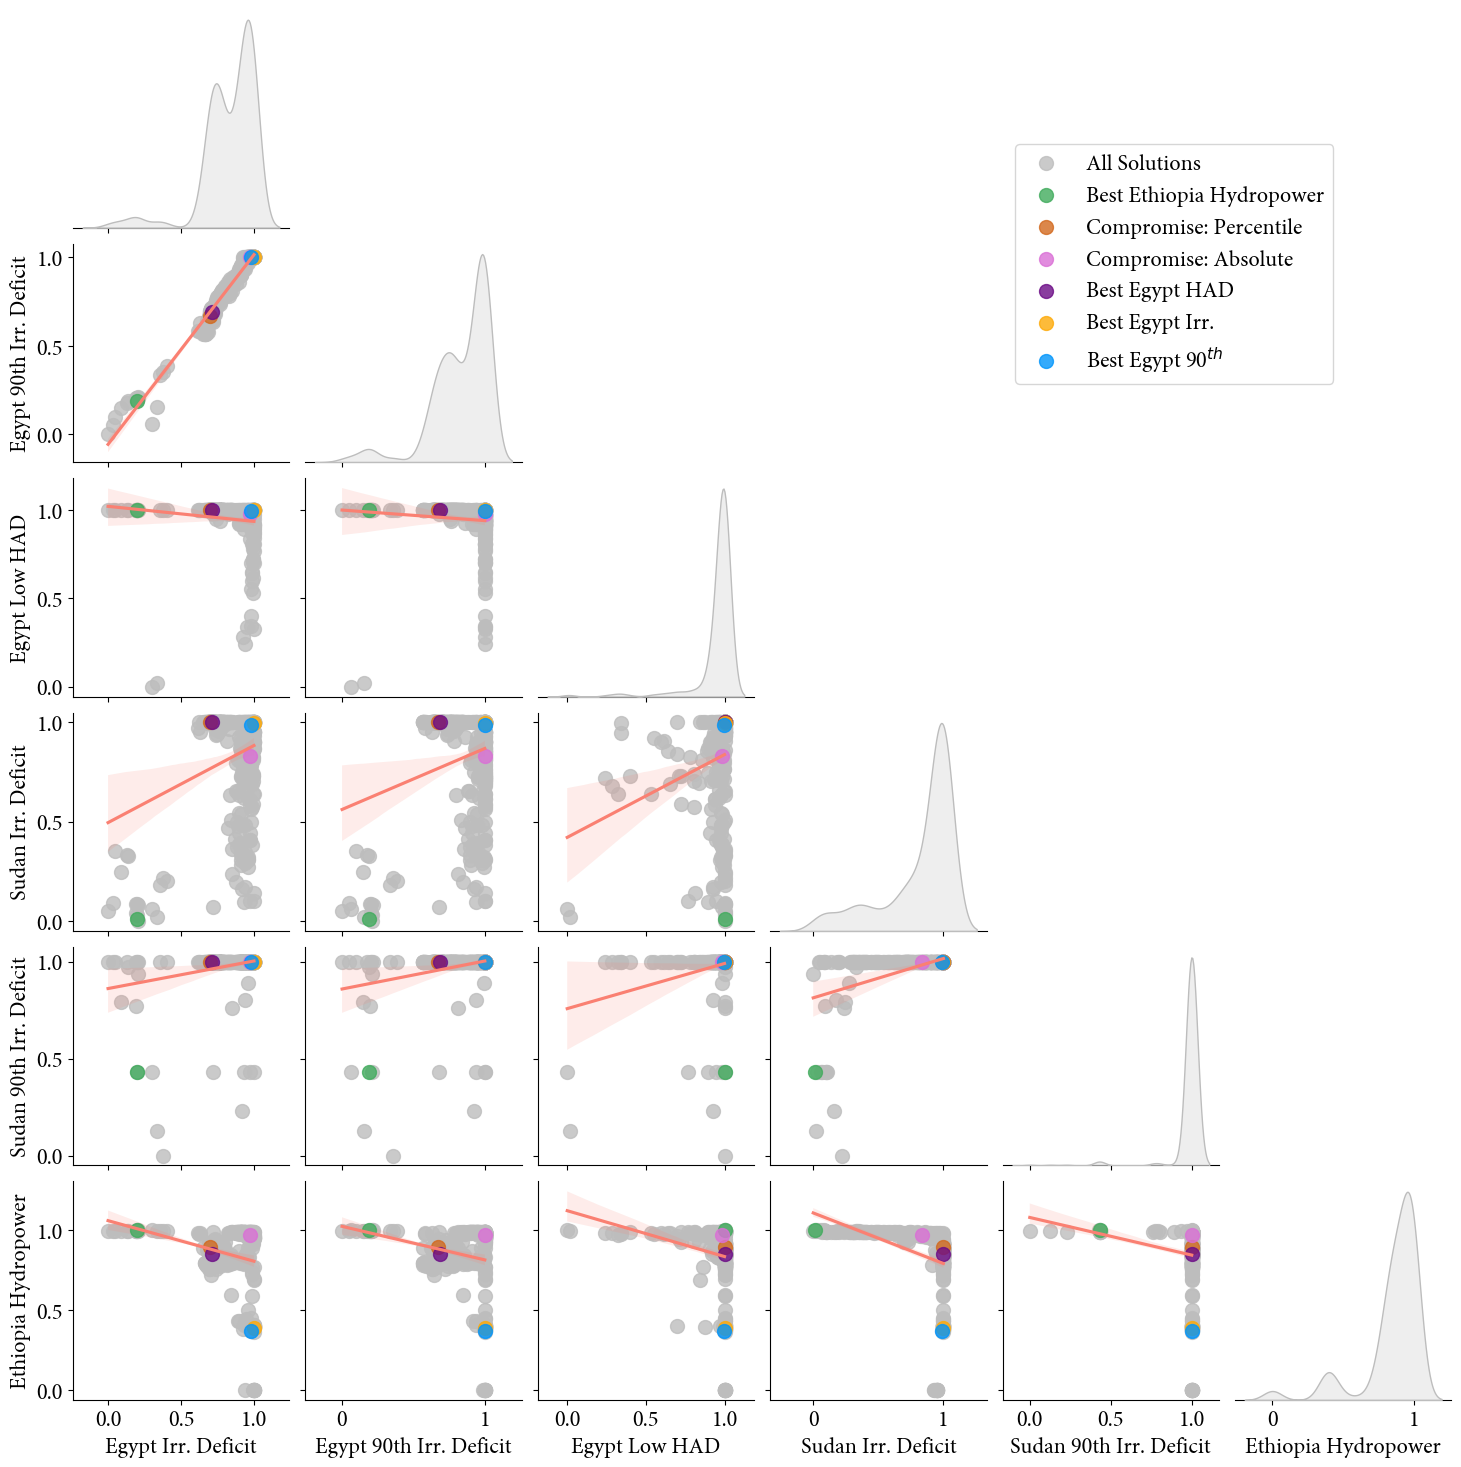

---------
HighBlueNile
---------



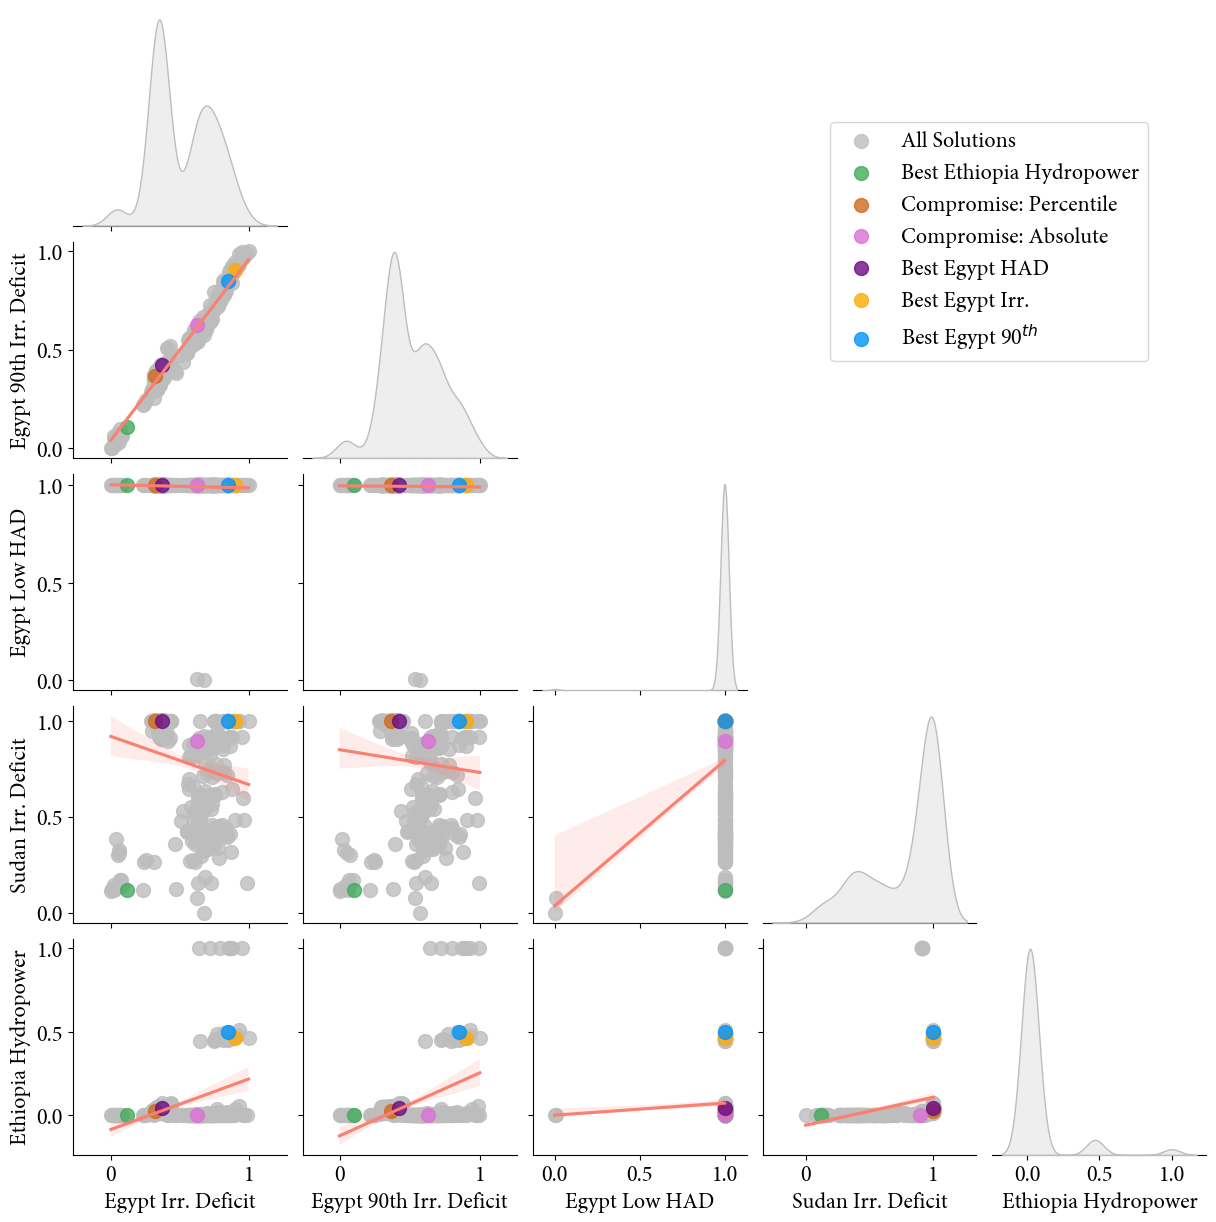

In [23]:
solution_indices = [271, 328, 265, 86, 165, 248]
solution_names = [
    "Best Egypt Irr.",
    "Best Egypt 90$^{th}$",
    "Best Egypt HAD",
    "Best Ethiopia Hydropower",
    "Compromise: Percentile",
    "Compromise: Absolute",
]

policy_colors = {
    "Best Egypt 90$^{th}$": "#0195fb",
    "Best Egypt HAD": "#6C0C86",
    "Compromise: Absolute": "orchid",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Best Egypt Irr.": "#fdaa09",
    "Compromise: Percentile": "chocolate",
    "All Solutions": "#bdbdbd"
}

directions_dict = {
    "egypt_irr": "min",
    "egypt_90": "min",
    "egypt_low_had": "min",
    "sudan_irr": "min",
    "sudan_90": "min",
    "ethiopia_hydro": "max"
}

for scen in experiments["scenario"].unique():
    print("---------")
    print(scen)
    print("---------\n")
    
    norm_df = normalize_objs(
            outcomes.loc[
                scenario_indexes[scen],
                slope_dfs[scen].dropna(axis=0, how="all").dropna(axis=1, how="all").columns,
            ],
            directions=[directions_dict[i] for i in slope_dfs[scen].columns],
        )[0].rename(columns = obj_names).reset_index(drop=True)
    
    
    norm_df["Name"] = "All Solutions"
    for i, solution_index in enumerate(solution_indices):
        norm_df.loc[solution_index, "Name"] = solution_names[i]
        # norm_df = norm_df.append(norm_df.loc[solution_index, :].copy())


    g = sns.pairplot(
        norm_df,
        corner=True,
        kind="reg",
        hue="Name",
        diag_kind="kde",
        plot_kws={"line_kws": {"color": "salmon"}, "scatter_kws": {"s": 100}},
        palette=policy_colors
    )
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g._legend.remove()
    g.fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.75,0.90))
    plt.savefig(f"../plots/resimulation/{scen}_scenario_pairplot.svg")
    plt.show()

# g = sns.pairplot(normalize_objs(outcomes.loc[scenario_indexes["HighD_LowWh"],['egypt_irr', 'egypt_90', 'sudan_irr','ethiopia_hydro']],
#                             directions=["min", "min","min","max"])[0],
#              corner=True, kind="reg", diag_kind= "kde",plot_kws={'line_kws':{'color':'red'}})
# g.axes[3,0].set_xlim((0,1))
# g.axes[3,0].set_ylim((0,1.2))